# Planet Amazon Image Classification - Deep Learning - Upsampling

The labels can broadly be broken into three groups: atmospheric conditions, common land cover/land use phenomena, and rare land cover/land use phenomena. Each chip will have one and potentially more than one atmospheric label and zero or more common and rare labels.
The common labels in this data set are rainforest, agriculture, rivers, towns/cities, and roads. The overwhelming majority of the data set is labeled as "primary"

## Importing the Data

In [1]:
#import modules
import numpy as np 
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
#import pickle
from IPython.display import display
from skimage import io
%matplotlib inline

# Define files and directories
#os.chdir('C:/Users/isado/Documents/SpringBoard/Capstone2/')
         
# Create DataFrame with training labels
#train_labels = pd.read_csv('./train_classes.csv')
train_labels = pd.read_csv('/floyd/input/amazon_train_classes/train_classes.csv')

train_labels

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road
...,...,...
40474,train_40474,clear primary
40475,train_40475,cloudy
40476,train_40476,agriculture clear primary
40477,train_40477,agriculture clear primary road


In [2]:
#Extracting unique labels
labels = []
for tags in train_labels.tags.values:
    label = tags.split(' ')
    for subitem in label:
        if subitem not in labels:
            labels.append(subitem)

#One Hot encoding labels
for label in labels:
    train_labels[label] = train_labels['tags'].apply(lambda x: 1 if label in x.split(' ') else 0)
    
train_labels.index = train_labels.image_name

In [3]:
from skimage.transform import resize
from skimage.color import rgb2gray

#Write function to get a specific image

def load_image(file_name, fig_type='jpg', size=256, n_channels=3):
    
    """Loads the requested image resized and converted to gray if n_channels == 1 specified"""
    
    #img_path = ('./train-{}/{}.{}').format(fig_type,file_name,fig_type)
    img_path = ('/floyd/input/amazon_images/{}.{}').format(file_name,fig_type)
    img = io.imread(img_path)
    img = resize(img, (size,size,3), mode='constant')
    if n_channels == 1:
        img = rgb2gray(img)[:, :, np.newaxis]
    
    return img

In [4]:
#Create a lookup dictionary containing the labels for each image sample

labels_dict={}
labels_array = np.array(train_labels.iloc[:,-17:])

for i, sample in enumerate(train_labels.index):
    labels_dict[sample] = labels_array[i]

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# import keras library
import keras

# import Sequential from the keras models module
from keras.models import Sequential

# import Dense, Dropout, Flatten, Conv2D, MaxPooling2D from the keras layers module
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

Using TensorFlow backend.


In [6]:
#RAM size limitation makes it so we have to process our data in mini-batches

from skimage.io import imread
from skimage.transform import resize
import numpy as np
import math

#adapted from https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
class DataGenerator(keras.utils.Sequence):
    
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, batch_size=64, dim=(64,64), n_channels=3,
                 n_classes=10, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = list(np.empty((self.batch_size)))

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i,] = load_image(ID, size=self.dim[0], n_channels=self.n_channels)

            # Store class
            y[i] = self.labels[ID]

        return X, np.array(y)

In [7]:
#Write function to get f1-score metric for Keras
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


## Baseline CNN Neural Net
 - Batch size = 256
 - Training set size = 5000
 - Validation set size = 5000
 - Image Res: 64x64 RGB
 - Early stopping: validation loss with patience of 5
 - Metric: F1 score

In [8]:
# Parameters
params = {'dim': (64,64),
          'batch_size': 512,
          'n_classes': 17,
          'n_channels': 3,
          'shuffle': True}

# Import the EarlyStopping and ModelCheckpoint callbacks
from keras.callbacks import EarlyStopping, ModelCheckpoint


# Save the best model as best_amazonimages_model.hdf5
#modelCheckpoint = ModelCheckpoint('best_amazonimages_model.hdf5', save_best_only = True)

# Define a callback to monitor validation accuracy
monitor_val_loss = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Generators
training_generator = DataGenerator(train_labels.index[0:5000], labels_dict, **params)
validation_generator = DataGenerator(train_labels.index[30000:35000], labels_dict, **params)

#Design Model################################

# define model as Sequential
model = Sequential()

# first convolutional layer with 32 filters
model.add(Conv2D(32, kernel_size=(8, 8), activation='relu', input_shape=(64, 64, 3)))

# add a second 2D convolutional layer with 64 filters
model.add(Conv2D(64, kernel_size=(8, 8), activation='relu', input_shape=(64, 64, 3)))

# reduce dimensionality through max pooling
model.add(MaxPooling2D(pool_size=(4,4)))

# third convolutional layer with 64 filters
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))

# add dropout to prevent over fitting
model.add(Dropout(0.5))

# necessary flatten step preceeding dense layer
model.add(Flatten())

# fully connected layer
model.add(Dense(128, activation='relu'))

# add additional dropout to prevent overfitting
model.add(Dropout(0.5))

# prediction layers
model.add(Dense(17, activation='sigmoid', name='preds'))

model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy',f1_m,precision_m, recall_m])

In [9]:
# Train model on dataset
history = model.fit_generator(generator=training_generator,
                    validation_data=validation_generator, epochs = 50, callbacks=[monitor_val_loss],
                    use_multiprocessing=True,
                    workers=6)

Epoch 1/50
9/9 [==============================] - 130s 14s/step - loss: 0.4718 - accuracy: 0.8065 - f1_m: 0.4917 - precision_m: 0.5014 - recall_m: 0.5085 - val_loss: 0.3179 - val_accuracy: 0.9051 - val_f1_m: 0.6682 - val_precision_m: 0.8127 - val_recall_m: 0.5674
Epoch 2/50
9/9 [==============================] - 105s 12s/step - loss: 0.3658 - accuracy: 0.8727 - f1_m: 0.5870 - precision_m: 0.6462 - recall_m: 0.5379 - val_loss: 0.2893 - val_accuracy: 0.9051 - val_f1_m: 0.6686 - val_precision_m: 0.8132 - val_recall_m: 0.5678
Epoch 3/50
9/9 [==============================] - 107s 12s/step - loss: 0.3141 - accuracy: 0.8850 - f1_m: 0.6145 - precision_m: 0.7047 - recall_m: 0.5451 - val_loss: 0.2540 - val_accuracy: 0.9048 - val_f1_m: 0.6678 - val_precision_m: 0.8127 - val_recall_m: 0.5668
Epoch 4/50
9/9 [==============================] - 107s 12s/step - loss: 0.2935 - accuracy: 0.8926 - f1_m: 0.6378 - precision_m: 0.7391 - recall_m: 0.5610 - val_loss: 0.2609 - val_accuracy: 0.9053 - val_f1_m: 

In [20]:
# save model and architecture to a h5 file
model.save("mini_baseline_model_2000n.h5")
print("Saved model to disk")

Saved model to disk


In [21]:
def plot_loss(loss,val_loss):
    """Plots loss as a function of epoch for validation 
           and training sets"""
    
    plt.figure()
    plt.plot(loss)
    plt.plot(val_loss)
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper right')
    plt.show()

def plot_accuracy(acc,val_acc):
    """Plots loss as a function of epoch for validation 
           and training sets"""
    
    plt.figure()
    plt.plot(acc)
    plt.plot(val_acc)
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper right')
    plt.show()

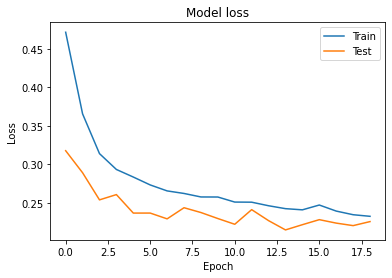

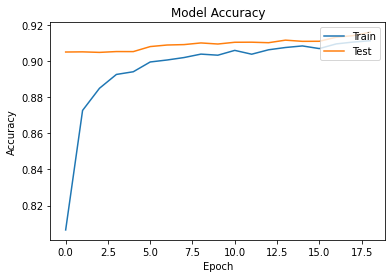

In [22]:
# Plot train vs test loss during training
plot_loss(history.history['loss'], history.history['val_loss'])

# Plot train vs test accuracy during training
plot_accuracy(history.history['accuracy'], history.history['val_accuracy'])

In [23]:
# Evaluating model using test set
params = {'dim': (64,64),
          'batch_size': 256,
          'n_classes': 17,
          'n_channels': 3,
          'shuffle': False}

test_set = train_labels.index[35000:40376]#test size needs to be an exact multiple of the batch size specified by the data generator

test_generator = DataGenerator(test_set, labels_dict, **params)

# make predictions on the testing images
preds = model.predict_generator(test_generator,steps=len(test_set)//params['batch_size'],verbose=1)

21/21 [==============================] - 43s 2s/step


In [24]:
truelabels = train_labels.loc[test_set].iloc[:,-17:].values

In [25]:
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_curve

def class_f1_calc(predictions, truelabels):
    "Returns a dataframe with f1 score values broken down per class for various Thresholds"

    #Initialize a dictionary for accuracy, this dictionary will breakdown accuracy per threshold
    class_f1 = {}
    #Initialize class predictions with all zeros
    preds_threshold = np.zeros(truelabels.shape)

    for threshold in np.arange(0,1.05,0.05):

        #initialize dictionary to hold accuracy per threshold
        class_f1['Threshold: {:.2f}'.format(threshold)] = {}
        i = 0

        for sample in predictions:
            preds_threshold[i] = [1 if class_proba>threshold else 0 for class_proba in sample]
            i += 1

        #flatten array before calling accuracy score to get overall acuracy metric
        class_f1['Threshold: {:.2f}'.format(threshold)]['Overall'] = f1_score(np.ndarray.flatten(truelabels), np.ndarray.flatten(preds_threshold))

        for column_idx in range(len(labels)):
            class_predictions = preds_threshold[:,column_idx]
            true_labels_class = truelabels[:,column_idx]
            class_f1['Threshold: {:.2f}'.format(threshold)][labels[column_idx]] = f1_score(np.ndarray.flatten(true_labels_class), np.ndarray.flatten(class_predictions))

    return (pd.DataFrame.from_dict(class_f1).T)

In [26]:
baseline_model_performance = class_f1_calc(preds, truelabels)
baseline_model_performance

,Overall,haze,primary,agriculture,clear,water,habitation,road,cultivation,slash_burn,cloudy,partly_cloudy,conventional_mine,bare_ground,artisinal_mine,blooming,selective_logging,blow_down
Threshold: 0.00,0.289372,0.123560,0.964062,0.471642,0.827609,0.302762,0.162051,0.329397,0.204109,0.013671,0.089892,0.306772,0.00223,0.04793,0.017699,0.014404,0.016236,0.004454
Threshold: 0.05,0.507222,0.270161,0.964062,0.471642,0.827609,0.302762,0.218002,0.335992,0.211241,0.000000,0.376190,0.306772,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000
Threshold: 0.10,0.563173,0.368074,0.964062,0.490246,0.827789,0.316633,0.224380,0.394128,0.214640,0.000000,0.552910,0.340807,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000
Threshold: 0.15,0.627626,0.298397,0.964062,0.529030,0.831052,0.335255,0.160183,0.414815,0.016194,0.000000,0.603710,0.353779,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000
Threshold: 0.20,0.654072,0.000000,0.964062,0.546999,0.836640,0.327138,0.000000,0.423138,0.000000,0.000000,0.596421,0.350724,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000
Threshold: 0.25,0.675878,0.000000,0.964062,0.551584,0.841860,0.265085,0.000000,0.428441,0.000000,0.000000,0.577181,0.322998,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000
Threshold: 0.30,0.691992,0.000000,0.964062,0.547572,0.848247,0.000000,0.000000,0.413009,0.000000,0.000000,0.533333,0.208222,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000
Threshold: 0.35,0.700852,0.000000,0.964062,0.535929,0.855591,0.000000,0.000000,0.255675,0.000000,0.000000,0.484043,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000
Threshold: 0.40,0.701791,0.000000,0.964062,0.518698,0.860876,0.000000,0.000000,0.000000,0.000000,0.000000,0.425287,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000
Threshold: 0.45,0.700636,0.000000,0.964062,0.466250,0.866107,0.000000,0.000000,0.000000,0.000000,0.000000,0.351852,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000


# Upsampling Blow Down

In [55]:
from sklearn.utils import resample

#Check effects of upsampling minority class (selective logging)

training_set = train_labels.iloc[0:30000] #all the data not used for validation or testing
blowdown_train_samples = training_set[training_set['blow_down']==1]
 
# Upsample the minority class
blowdown_upsampled = resample(blowdown_train_samples, 
                                 replace=True,     # sample with replacement
                                 n_samples= 2000,    #original number of samples was 76
                                 random_state=12) # reproducible results


# Combine training set with upsampled minority class
blowdown_upsampled = pd.concat([train_labels.iloc[0:5000,:], blowdown_upsampled])

In [60]:
# Parameters
params = {'dim': (64,64),
          'batch_size': 512,
          'n_classes': 17,
          'n_channels': 3,
          'shuffle': True}

# Import the EarlyStopping and ModelCheckpoint callbacks
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Define a callback to monitor validation accuracy
monitor_val_loss = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Generators
training_generator = DataGenerator(blowdown_upsampled.index, labels_dict, **params)
validation_generator = DataGenerator(train_labels.index[30000:35000], labels_dict, **params)

#Design Model################################

# define model as Sequential
model = Sequential()

# first convolutional layer with 32 filters
model.add(Conv2D(32, kernel_size=(8, 8), activation='relu', input_shape=(64, 64, 3)))

# add a second 2D convolutional layer with 64 filters
model.add(Conv2D(64, kernel_size=(8, 8), activation='relu', input_shape=(64, 64, 3)))

# reduce dimensionality through max pooling
model.add(MaxPooling2D(pool_size=(4,4)))

# third convolutional layer with 64 filters
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))

# add dropout to prevent over fitting
model.add(Dropout(0.5))

# necessary flatten step preceeding dense layer
model.add(Flatten())

# fully connected layer
model.add(Dense(128, activation='relu'))

# add additional dropout to prevent overfitting
model.add(Dropout(0.5))

# prediction layers
model.add(Dense(17, activation='sigmoid', name='preds'))

model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy',f1_m,precision_m, recall_m])

In [61]:
# Train model on dataset
history = model.fit_generator(generator=training_generator,
                    validation_data=validation_generator, epochs = 50, callbacks=[monitor_val_loss],
                    use_multiprocessing=True,
                    workers=6)

Epoch 1/50
13/13 [==============================] - 169s 13s/step - loss: 0.4550 - accuracy: 0.8135 - f1_m: 0.5050 - precision_m: 0.5345 - recall_m: 0.4994 - val_loss: 0.3105 - val_accuracy: 0.9060 - val_f1_m: 0.6709 - val_precision_m: 0.8147 - val_recall_m: 0.5703
Epoch 2/50
13/13 [==============================] - 144s 11s/step - loss: 0.3442 - accuracy: 0.8758 - f1_m: 0.6030 - precision_m: 0.7001 - recall_m: 0.5302 - val_loss: 0.2813 - val_accuracy: 0.9050 - val_f1_m: 0.6684 - val_precision_m: 0.8146 - val_recall_m: 0.5668
Epoch 3/50
13/13 [==============================] - 143s 11s/step - loss: 0.3004 - accuracy: 0.8885 - f1_m: 0.6382 - precision_m: 0.7568 - recall_m: 0.5522 - val_loss: 0.2373 - val_accuracy: 0.9091 - val_f1_m: 0.6704 - val_precision_m: 0.8621 - val_recall_m: 0.5487
Epoch 4/50
13/13 [==============================] - 142s 11s/step - loss: 0.2808 - accuracy: 0.8950 - f1_m: 0.6548 - precision_m: 0.7894 - recall_m: 0.5597 - val_loss: 0.2507 - val_accuracy: 0.9102 - va

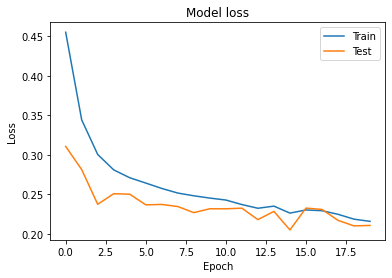

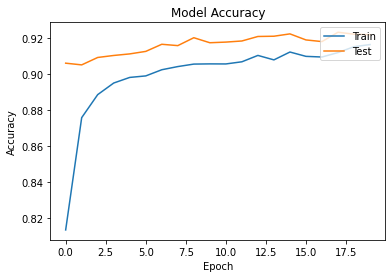

In [67]:
# Plot train vs test loss during training
plot_loss(history.history['loss'], history.history['val_loss'])

# Plot train vs test accuracy during training
plot_accuracy(history.history['accuracy'], history.history['val_accuracy'])

In [63]:
# save model and architecture to a tf file
model.save("mini_upsampled_model_2000n.tf")
print("Saved model to disk")

Saved model to disk


In [69]:
# Evaluating model using test set
test_generator = DataGenerator(test_set, labels_dict, **params)

# make predictions on the testing images
preds_upsampled = model.predict_generator(test_generator,steps=len(test_set)//params['batch_size'],verbose=1)

10/10 [==============================] - 43s 4s/step


In [70]:
upsampled_model_performance = class_f1_calc(preds_upsampled, truelabels)
upsampled_model_performance

,Overall,haze,primary,agriculture,clear,water,habitation,road,cultivation,slash_burn,cloudy,partly_cloudy,conventional_mine,bare_ground,artisinal_mine,blooming,selective_logging,blow_down
Threshold: 0.00,0.287590,0.123128,0.940828,0.466736,0.809871,0.303010,0.163389,0.328479,0.202408,0.014349,0.089708,0.305875,0.002341,0.047220,0.017028,0.014732,0.015879,0.004677
Threshold: 0.05,0.450507,0.109800,0.940828,0.466232,0.798350,0.302590,0.154497,0.307194,0.199181,0.000000,0.072027,0.304413,0.000000,0.049881,0.013986,0.000000,0.000000,0.004991
Threshold: 0.10,0.491316,0.094488,0.940409,0.463312,0.792072,0.289679,0.136580,0.283651,0.185198,0.000000,0.050119,0.267241,0.000000,0.000000,0.000000,0.000000,0.000000,0.004718
Threshold: 0.15,0.515488,0.097514,0.939325,0.439186,0.784309,0.248239,0.133245,0.254777,0.105465,0.000000,0.049419,0.242839,0.000000,0.000000,0.000000,0.000000,0.000000,0.005121
Threshold: 0.20,0.524720,0.087273,0.936458,0.382710,0.774973,0.221860,0.105873,0.237608,0.003226,0.000000,0.052288,0.216396,0.000000,0.000000,0.000000,0.000000,0.000000,0.004950
Threshold: 0.25,0.535578,0.074294,0.934447,0.343538,0.766815,0.195437,0.061979,0.225615,0.000000,0.000000,0.049734,0.197357,0.000000,0.000000,0.000000,0.000000,0.000000,0.004725
Threshold: 0.30,0.548566,0.048696,0.932203,0.316994,0.761133,0.153285,0.007299,0.206393,0.000000,0.000000,0.042308,0.171723,0.000000,0.000000,0.000000,0.000000,0.000000,0.004637
Threshold: 0.35,0.558860,0.029228,0.929107,0.295433,0.753396,0.089402,0.000000,0.194363,0.000000,0.000000,0.044177,0.126301,0.000000,0.000000,0.000000,0.000000,0.000000,0.004847
Threshold: 0.40,0.587861,0.014706,0.927440,0.267026,0.746069,0.064412,0.000000,0.184170,0.000000,0.000000,0.042283,0.066932,0.000000,0.000000,0.000000,0.000000,0.000000,0.003643
Threshold: 0.45,0.598049,0.000000,0.925487,0.235846,0.738030,0.054674,0.000000,0.164338,0.000000,0.000000,0.040000,0.042517,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
